In [1]:
import sys
print sys.version

2.7.14 |Anaconda custom (64-bit)| (default, Oct 15 2017, 03:34:40) [MSC v.1500 64 bit (AMD64)]


In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
import pandas as pd
import numpy as np
import time

import requests, dill, re
from bs4 import BeautifulSoup
import nltk#, spacy

from datetime import datetime, date
from requests_futures.sessions import FuturesSession
from concurrent.futures import ThreadPoolExecutor

# The New York Social Graph

[New York Social Diary](http://www.newyorksocialdiary.com/party-pictures) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.

Besides the brand-name celebrities, you will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties dated December 1, 2007, and before. Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

## Phase One

Define a function that extracts information (link and date) for every event. 

In [2]:
from requests_futures.sessions import FuturesSession
from concurrent.futures import ThreadPoolExecutor

def generate_actual_url(it):
    return 'http://www.newyorksocialdiary.com/party-pictures?page=' + str(it)

def get_list_with_links(future):

    soup = BeautifulSoup(future.result().text, 'lxml')
    
    links, dates = [], []
    for el in soup.find_all('span', attrs={'class':'field-content'}):
        try:
            links.append(el.find('a').get('href'))
        except: 
            dates.append(datetime.strptime(el.text, '%A, %B %d, %Y'))           
    
    return links, dates
            


url_list = [generate_actual_url(it) for it in range(30)]
cut_date = datetime.strptime('2007-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')


session = FuturesSession(max_workers=10)
futures = [session.get(url) for url in url_list]

all_links, all_dates = [], []

for future in futures:
    links, dates = get_list_with_links(future)
    all_links.extend(links)
    all_dates.extend(dates)

all_YM_dates = np.array([ date(item.year, item.month, 1) for item in all_dates]) 
    
df = pd.DataFrame({'links': all_links, 'dates': all_dates, 'dates_YM': all_YM_dates})
df = df[df['dates']<=cut_date]

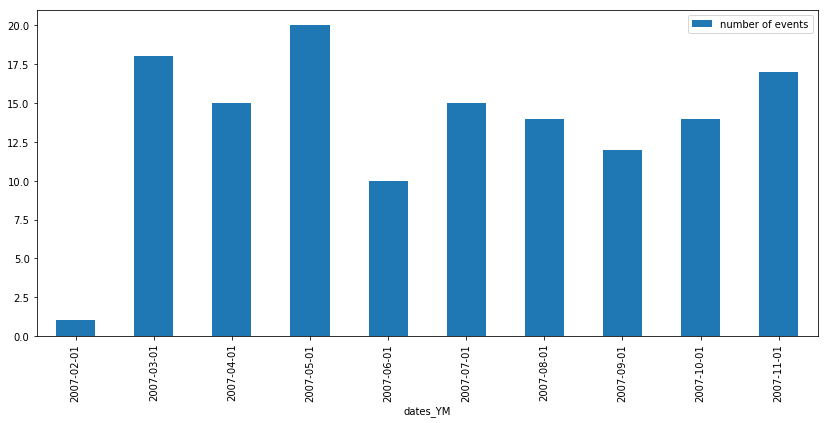

In [6]:
df[['dates_YM', 'links']].groupby('dates_YM').count().rename(index=str, columns={'links': 'number of events'}).plot(kind="bar", figsize=(14,6))

## Phase Two

Define a function that finds all photocaptions in a given web page and returns them as a list.

In [7]:
def remove_non_ascii_1(text):
    return ''.join([i if ord(i) < 128 else ' ' for i in text])

def get_captions(url):
    '''
    Obtain a list of all photocaptions in a given web page.
    '''
    captions = []
    soup = BeautifulSoup(requests.get(url).text, 'lxml')
    
    for el in soup.find_all('div', attrs={'class':'photocaption'}):
        try: captions.append(el.text.strip().replace("  ", " "))
        except: pass
        
    for el in soup.find_all('font', attrs={'size':'1'}):
        if len(el.text)<250:
            try: captions.append(re.sub('[\s]+', ' ', remove_non_ascii_1(el.text) ).strip()  )
            except: pass
        
    return captions


#### example
url = 'http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood'
captions = get_captions(url)
captions_2 = [remove_non_ascii_1(caption) for caption in captions]

## Phase Three
Extract the names from the photocaptions.   
In the example "Richard and Donna Soloway" nltk can extract the names "Richard", "Donna Soloway" instead of "Richard Soloway", "Donna Soloway". To correct this we propose two solutions. The first solution is implemented with **nltk**.

In [8]:
import nltk
from nameparser.parser import HumanName
#nltk.help.upenn_tagset()

def get_human_names_v1(text):
    
    tokens = nltk.tokenize.word_tokenize(text)
    pos    = nltk.pos_tag(tokens)                # assign a part of speech to every token
    sentt  = nltk.ne_chunk(pos, binary = False)  # chunking

    names_list = []
    tmp = None          # in cases of the form: "John and Ally FAMILY_NAME", tmp has to catch 'John'.
                        # This variable is used later in the reconstruction of "John FAMILY_NAME"
    
    for subtree in sentt.subtrees(filter = lambda x: x.label() == 'PERSON'):
    
        person = []
        for leaf in subtree.leaves():
            person.append(leaf[0])

        if len(person)>1:
            # if the person has FIRST_NAME and FAMILY_NAME then assign it to the list
            names_list.append( ' '.join(person) )
        
            # if there is a person from the previous subtree without a FAMILY_NAME then assign it to the FAMILY_NAME 
            # from the current subtree
            if tmp is not None:
                names_list.append( ' '.join([tmp, person[-1]]) )
                tmp = None

        # if the person has only a FIRST_NAME then assign to it a FAMILY_NAME from the next subtree
        elif len(person)==1:
            tmp = person[0]

    return (names_list)

The second solution is implemented with **spacy**.

In [9]:
import spacy
nlp = spacy.load('en')

def get_human_names_v2(text):

    names_list = []
    
    if len(text)==0:
        return names_list
    
    doc = nlp(text)
    t_var = None
    
    for id, ent in enumerate(doc.ents):
        if ent.label_=='PERSON':        
            if len(ent.text.split())==1: 
                t_var = ent.text
                
            if len(ent.text.split())>1:  
                names_list.append( ent.text.strip() )
                if t_var is not None:
                    names_list.append( t_var + ' ' + ent.text.split()[-1] ) 
                    t_var = None
    return names_list

In the following we will apply the three solutions to two examples and see that none of them works perfectly.

In [10]:
text_1 = u'Kamie Lightburn and Christopher Spitzmiller'
text_2 = u'Kathy and Othon Prounis'
text_3 = u'Rick and Leticia Presutti'

print text_1
print get_human_names_v1(text_1)
print get_human_names_v2(text_1)
print '\n\n'

print text_2
print get_human_names_v1(text_2)
print get_human_names_v2(text_2)
print '\n\n'

print text_3
print get_human_names_v1(text_3)
print get_human_names_v2(text_3)

Kamie Lightburn and Christopher Spitzmiller
[u'Christopher Spitzmiller', u'Kamie Spitzmiller']
[u'Kamie Lightburn', u'Christopher Spitzmiller']



Kathy and Othon Prounis
[u'Othon Prounis', u'Kathy Prounis']
[]



Rick and Leticia Presutti
[u'Leticia Presutti', u'Rick Presutti']
[u'Leticia Presutti', u'Rick Presutti']


## Phase Four

Parse all of the captions and extract all the names.  
Run this for all of the pages.  

In [11]:
# Scraping all of the pages could take several minutes.

url_list = [generate_actual_url(it) for it in range(30)]
cut_date = datetime.strptime('2007-12-01 00:00:00', '%Y-%m-%d %H:%M:%S')


session = FuturesSession(max_workers=10)
futures =  [session.get(url) for url in url_list]


all_links, all_dates = [], []

for future in futures:
    links, dates = get_list_with_links(future)
    all_links.extend(links)
    all_dates.extend(dates)


df = pd.DataFrame({'links': all_links, 'dates': all_dates})
df = df[df['dates']<=cut_date]

list_caption_list = [get_captions('http://www.newyorksocialdiary.com' + row['links']) for index, row in df.iterrows()] 

list_list_list_name = [[sorted(get_human_names_v2(caption)) for caption in caption_list] for caption_list in list_caption_list]

### Histogram of the number of photo-captions per page

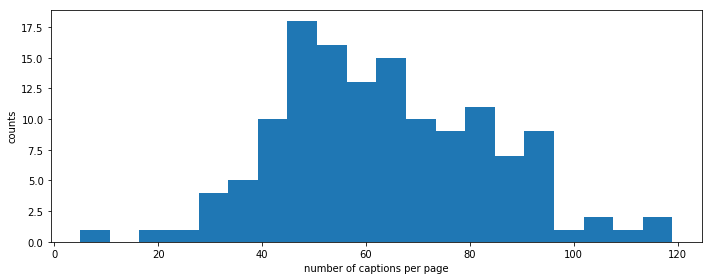

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt

captions_found = [len(caption_list) for caption_list in list_caption_list]

plt.figure(figsize=(10,4))

plt.hist( captions_found, bins=20 )
plt.xlabel( 'number of captions per page' )
plt.ylabel( 'counts' )
plt.tight_layout()

plt.show()

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  In this problem, we will analyze the social graph of the new york social elite.  We recommend using python's [networkx](https://networkx.github.io/) library.

## The most popular person

From every caption generate all possible pairs of names.  
Use this pairs to construct an undirected graph.  
The weight of every edge is equal to the number of times a given pair appears together in a photocaption.  

We will use this graph to answer the question who is the most popular.

In [21]:
import itertools
import networkx as nx

def get_APP_of_names_from_list_names(list_names):
    '''
    generate all possible pairs of names that appear in the same caption
    '''
    APP = []
    for j in range(len(list_names)):
        for i in range(j):
            APP.append( [list_names[i], list_names[j]] )
    return APP


################################################################################ Graph generation
# the lists of names and of pairs of names are already ordered alphabetically
G=nx.Graph()
for list_list_name in list_list_list_name:
    for list_name in list_list_name:
        APP = get_APP_of_names_from_list_names(list_name)
        
        # crete all edges between pairs of friends
        for pair in APP:
            if G.has_edge(pair[0], pair[1]):
                G[pair[0]][pair[1]]['weight'] += 1
            else:
                G.add_edge(pair[0], pair[1], weight=1)


################################################################################ person_pop
person_pop = {}
for node in G.nodes:
    person_pop[node] = 0
    for edge in G.edges(node, data=True): 
        person_pop[node] += edge[2]['weight']

person_pop_list = []
for key, value in person_pop.iteritems(): 
    person_pop_list.append( [key,value] )

person_pop_list.sort(key=lambda x: x[1], reverse=True)

ten_most_popular_people = [ (str(person_pop_list[i][0]),person_pop_list[i][1]) for i in range(10)]

In [22]:
ten_most_popular_people

[('Gillian Miniter', 81),
 ('Deborah Norville', 55),
 ('Andrew Saffir', 41),
 ('Marty Richards', 37),
 ('Jamee Gregory', 37),
 ('Jill Zarin', 37),
 ('Ellen V. Futter', 36),
 ('Cynthia Lufkin', 36),
 ('Debbie Bancroft', 35),
 ('Fernanda Kellogg', 34)]

## The most popular person (pagerank)

A similar way to determine popularity is to look at their
[pagerank](http://en.wikipedia.org/wiki/PageRank).  Pagerank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph.

We will use 0.85 as the damping parameter so that there is a 15% chance of jumping to another vertex at random.

In [20]:
pr = nx.pagerank(G, alpha=0.85)

pr_list = []
for key, value in pr.iteritems(): pr_list.append( [key,value] )

pr_list.sort(key=lambda x: x[1], reverse=True)

pr_list[:10]

[[u'Gillian Miniter', 0.0013686007892371246],
 [u'Andrew Saffir', 0.0009334846969569304],
 [u'Deborah Norville', 0.0008149484230269106],
 [u'Marty Richards', 0.0007411259569899076],
 [u'Debbie Bancroft', 0.0006843209817207661],
 [u'Jamee Gregory', 0.0006835008585135931],
 [u'David Dinkins', 0.0006310602890995364],
 [u'Fernanda Kellogg', 0.000614329015347217],
 [u'Cynthia Lufkin', 0.0006141223066461702],
 [u'Dennis Basso', 0.0006116859272215007]]

## Best friends

Another interesting question is who tend to co-occur with each other.  
We will get the 10 edges with the highest weights.

In [26]:
couples_list = []

for edge in G.edges(data=True):
    couples_list.append( [ (edge[0],edge[1]), edge[2]['weight']] )

couples_list.sort(key=lambda x: x[1], reverse=True)

couples_list[:10]

[[(u'Peter Gregory', u'Jamee Gregory'), 8],
 [(u'Dan Lufkin', u'Cynthia Lufkin'), 8],
 [(u'Barbara Tober', u'Donald Tober'), 8],
 [(u'John K. Castle', u'John J. Connolly'), 8],
 [(u'Deborah Norville', u'Karl Wellner'), 7],
 [(u'Andrew Saffir', u'Daniel Benedict'), 6],
 [(u'Ann Leary', u'Dani Shapiro'), 6],
 [(u'Rachel Roy', u'Damon Dash'), 6],
 [(u'Bobby Zarin', u'Jill Zarin'), 6],
 [(u'Lauren Bush', u'David Lauren'), 5]]

In [ ]:
def get_human_names_v1(text):
    
    tokens = nltk.tokenize.word_tokenize(text)
    pos    = nltk.pos_tag(tokens)                # assign a part of speech to every token
    sentt  = nltk.ne_chunk(pos, binary = False)  # chunking

    names_list = []
    
    for subtree in sentt.subtrees(filter = lambda x: x.label() == 'PERSON'):
    
        person = []
        for leaf in subtree.leaves():
            person.append(leaf[0])

        if len(person)>1:
            # if the person has FIRST_NAME and FAMILY_NAME then assign it to the list
            names_list.append( ' '.join(person) )

    return (names_list)





In [ ]:
#text   = captions_2[2]
#tokens = nltk.tokenize.word_tokenize(text)
#pos    = nltk.pos_tag(tokens)                # assign a part of speech to every token
#sentt  = nltk.ne_chunk(pos, binary = False) 
#
#print captions_2[2]
#print tokens
#print pos
#sentt